In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import *
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import datetime
from keras.utils import plot_model

In [2]:
models_path = "./models/"

training_path = "C:/Users/AADIL/OneDrive/Documents/WasteImagesDataset/TRAIN"
test_path = "C:/Users/AADIL/OneDrive/Documents/WasteImagesDataset/TEST"
validation_path = "C:/Users/AADIL/OneDrive/Documents/WasteImagesDataset/VAL"

IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
BATCH_SIZE = 128
NUM_CLASSES = 4
RANDOM_SEED = 42

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    training_path,
    label_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

validation_dataset = image_dataset_from_directory(
    validation_path,
    label_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

test_dataset = image_dataset_from_directory(
    test_path,
    label_mode='categorical',
    shuffle=False,
    seed=RANDOM_SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 2797 files belonging to 4 classes.
Found 755 files belonging to 4 classes.
Found 724 files belonging to 4 classes.


In [4]:
def plot_accuracy_loss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  best_loss_epoch = np.argmin(val_loss)
  best_loss = np.min(val_loss)
  best_acc = val_acc[best_loss_epoch]

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training accuracy')
  plt.plot(epochs, val_acc, 'bo', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.show()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'bo', label='Validation loss')
  plt.plot(best_loss_epoch, best_loss, 'ro', label='Selected model')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()
  print(f"Lowest validation loss has been reached at epoch {best_loss_epoch:d} with validation accuracy of {best_acc:.3f}")
     

In [5]:
def eval (model):
  y_score = model.predict(test_dataset)
  test_loss, test_acc = model.evaluate(test_dataset)
  print(f"Test accuracy: {test_acc:.3f}, test loss: {test_loss:.3f}")
  y_pred = np.rint(y_score) # to have 0 or 1
  y_true = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)
  print("Classification report: ")
  print(type(y_true))
  print(type(y_pred))
  print(y_pred.argmax(axis=1))
  print(metrics.classification_report(y_true.numpy().argmax(axis=1),y_pred.argmax(axis=1),digits = 4))
  metrics.ConfusionMatrixDisplay.from_predictions(y_true.numpy().argmax(axis=1), y_pred.argmax(axis=1))



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                      

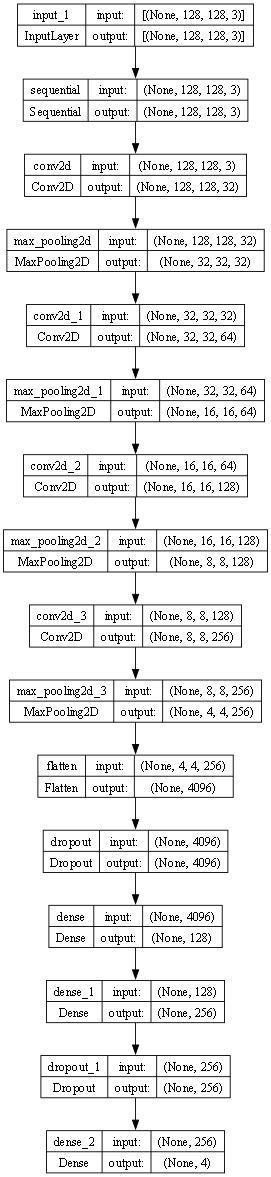

In [6]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
  layers.Rescaling(1./255)
])

inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = resize_and_rescale(inputs)
x = layers.Conv2D(filters=32, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=4)(x)
x = layers.Conv2D(filters=64, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

model_name = "TwoDropout128Dense"
model_path = os.path.join(models_path, model_name)
img_path = os.path.join(model_path, 'TwoDropout128Dense.png')
plot_model(model, show_shapes=True, to_file=img_path, dpi=64)

In [40]:
def compile_and_fit(model, model_name, model_path, learning_rate=None, optimizer='adam', train_dataset=train_dataset):

  save_path = os.path.join(model_path, model_name + '.h5')

  if learning_rate is not None:
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

  callbacks_list = [
    keras.callbacks.EarlyStopping(
      monitor='val_loss',
      min_delta=1e-3,
      patience=5,),
    keras.callbacks.ModelCheckpoint(
      filepath = save_path,
      monitor="val_loss",
      verbose=1,
      save_best_only=True)]

  history = model.fit(train_dataset, epochs=100, validation_data=validation_dataset, callbacks=callbacks_list)
  plot_accuracy_loss(history)

In [ ]:
compile_and_fit(model, model_name, model_path, learning_rate=0.0001)

6/6 [==============================] - 2s 181ms/step - loss: 0.6786 - accuracy: 0.7569
Test accuracy: 0.757, test loss: 0.679
Classification report: 
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
[0 0 0 0 0 2 0 0 2 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 3 0 0 0 0 3 0 2 3 0
 0 0 0 0 0 0 0 0 2 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 3 0 0 0 0 0 0 3 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 3 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3
 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 2 0 1 0 0 1 0 0
 2 1 0 1 0 0 0 1 0 0 2 1 1 1 2 0 0 0 1 1 1 2 1 1 0 1 1 1 0 0 1 0 1 1 0 1 1
 1 1 0 1 1 1 1 2 2 2 2 2 0 0 0 0 2 2 2 0 2 0 2 0 2 2 2 2 2 0 2 0 2 0 0 0 0
 2 2 2 2 2 0 0 0 2 2 1 0 2 2 0 0 0 0 3 2 2 2 2 0 3 2 2 0 2 2 0 2 2 2 2 2 2
 0 2 2 0 0 0 0 2 2 0 2

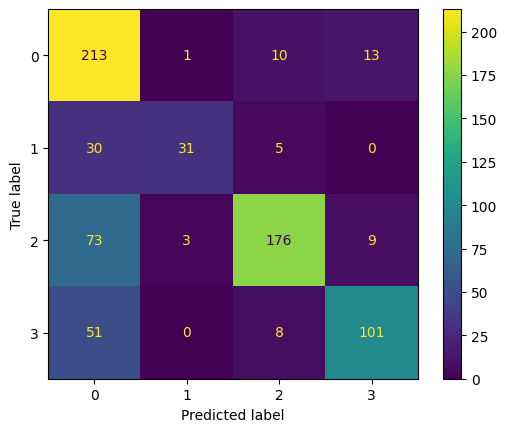

In [42]:
eval(tf.keras.models.load_model(os.path.join(model_path, model_name + '.h5')))